# Validación Cruzada, Curvas de Validación y Curvas de ROC

¡Gracias Martín Gonella por la creación de los contenidos de este encuentro!


En este notebook veremos cómo utilizar Validación Cruzada en Scikit-Learn. Luego, veremos cómo hacer una curva de validación incorporando esta técnica. Finalmente, haremos una curva ROC.


## 1. Validación Cruzada

En esta sección entrenaremos un modelo de árboles de decisión y uno de vecinos más cercanos sobre un nuevo dataset. Luego, evaluaremos estos modelos usando Validación Cruzada. 

### 1.1 Carga de Datos

Scikit-Learn provee varias funciones para cargar datasets y también para generar datasets. Hoy vamos a usar el Breast Cancer Wisconsin (diagnostic) dataset. Empezaremos cargando los datos y haciendo una pequeña exploración.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Si observan la variable `data`, podrán notar que es un `diccionario`, por lo tanto vamos a proceder a convertirlo en un `DataFrame` de Pandas.

In [ ]:
df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [ ]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


¡Ya tenemos nuestro dataset en un DataFrame de Pandas!

Comencemos con un poco de exploración.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Ahora veamos cuantos datos de cada etiqueta tenemos, para ellos debemos ver la columna `target`.

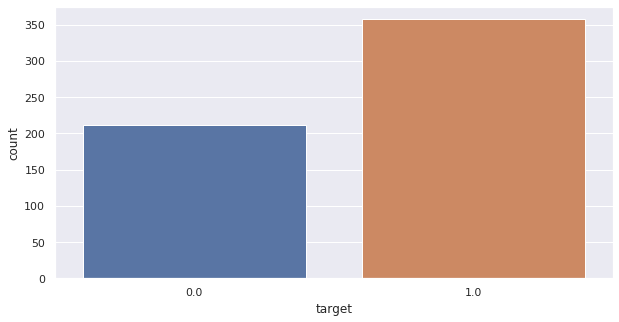

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['target'],label="Count")
plt.show()

Para facilitar el análisis, seleccionamos solo aquellas columnas donde los nombres de los atributos comiencen con la palabra `mean`.

In [ ]:
features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [ ]:
df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


**Ejercicio:** Ahora que ya filtramos las columnas con las cuales vamos a trabajar, crea un `pairplot()` y grafica una matriz de correlaciones. ¿Cuáles atributos están correlacionados?¿Se te ocurre por qué?

### 1.2 Entrenamiento de los modelos

Vamos a entrenar un árbol de decisión de profundidad infinita (`max_depth = None`) y un modelo de vecinos más cercanos con `n_neighbors=1`. Los vamos a entrenar y evaluar haciendo un `train_test_split` (con `test_size=0.10`) de los datos. Pero antes de eso, debemos seleccionar las variables de entrenamiento y la etiqueta.

In [ ]:
# X = df.drop(columns = ['target'])
X = df[['mean radius','mean smoothness', 'mean concave points']] #Observa que sólo usamos 3 features del dataset
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

Como ya hemos visto anteriormente, debemos proceder a reescalar los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

***Tip:*** Una buena práctica cuando separamos en conjuntos de `train` y `test` es chequear que las distribuciones que obtenemos sean similares. Obviamente, a medida que tenemos más features, esto se hace más difícil.

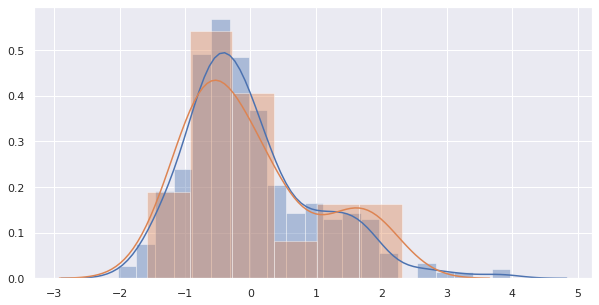

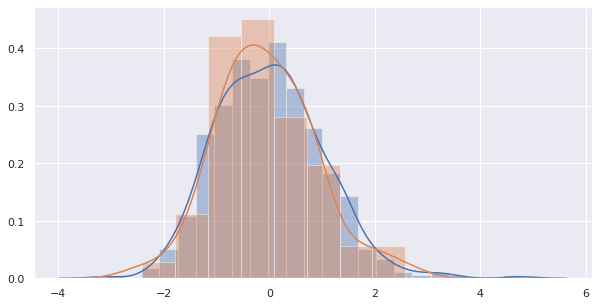

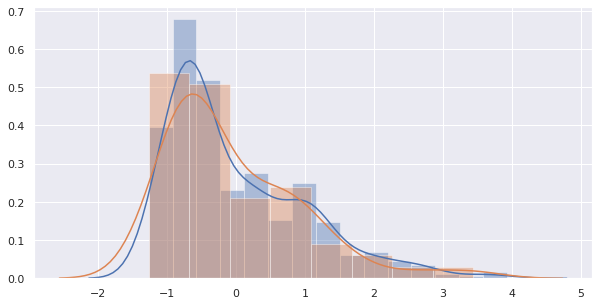

In [ ]:
for i in range(X_train.shape[1]):
    plt.figure(figsize=(10,5))
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Pero... ¿Será suficiente chequear esto?

***Tip 2:*** Otras cosa que podemos hacer es chequear que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida.

In [ ]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.62109375
Proporcion de etiquetas positiva en los datos de Test:  0.6842105263157895


**Para pensar:** Y si la proporcición no fuera parecida, ¿Qué deberíamos hacer? 

**Ejercicio:** ¿Qué hace el parámetro `stratify` de la función `train_test_split()`?

**Para pensar**: ¿Cuál será desempeño aproximado - accuracy - del modelo más sencillo que podemos crear para detectar casos positivos? Pensar en benchmarks.

#### A entrenar...

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#### `Árbol de Decisión`

In [ ]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


#### `KNN`

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8421052631578947


Bien, cada modelo obtuvo un determinado desempeño... Pero, ¿Este desempeño depende de la partición que hayamos hecho de los datos de `train/test`?

**Ejercicio:** Para ver si esto es cierto, vuelve a realizar la partición de datos pero ésta vez modifiquen el argumento `random_state` de la función `train_test_split()`. ¿Obtienes los mismos resultados?

### 1.3 Validación Cruzada

Vamos a evaluar los modelos que creamos utilizando validación cruzada.

Scikit-Learn tiene varias funciones ya incorporadas que evalúan los modelos usando validación cruzada. Las más sencilla de usar es `cross_val_score()`, que evalúa un score (para clasificaciones por defecto es el `Accuracy`) y de un modelo por CV.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)

In [ ]:
print(tree_scores, knn_scores)
# print(tree_scores.mean(), knn_scores.mean())
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

[0.88596491 0.88596491 0.92105263 0.92105263 0.84070796] [0.87719298 0.88596491 0.87719298 0.92105263 0.89380531]
Accuracy para Tree: 0.89 (+/- 0.06)
Accuracy para KNN: 0.89 (+/- 0.03)


¡Ahora podemos obtener una evaluación del modelo que no depende tanto de la partición hecha!

Por otra parte, `cross_validate()` es otra función muy parecida, pero un poco más versátil e informativa. Además de devolver los `scores`, devuelve algunas métricas que pueden ser útiles, como por ejemplo: tiempo de entrenamiento, los modelos entrenados, etc. Además, permite evaluar más de una métrica.

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
tree_scores = cross_validate(tree, X, y, cv=5)
knn_scores = cross_validate(knn, X, y, cv=5)

In [ ]:
print(tree_scores)
print(knn_scores)

{'fit_time': array([0.00506496, 0.00489235, 0.00307727, 0.00228381, 0.0020504 ]), 'score_time': array([0.00155187, 0.00099111, 0.00069618, 0.00069451, 0.00071335]), 'test_score': array([0.85964912, 0.88596491, 0.92982456, 0.9122807 , 0.88495575])}
{'fit_time': array([0.00126481, 0.00087667, 0.00087523, 0.00078845, 0.00071144]), 'score_time': array([0.00483561, 0.00412655, 0.00396919, 0.00361967, 0.00355792]), 'test_score': array([0.87719298, 0.88596491, 0.87719298, 0.92105263, 0.89380531])}


La siguiente celda imprime una lista de todas las métricas que podemos usar para evaluar con `cross_validate()`

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

**Ejercicio - Challenge:** Como habrás notado antes de entrenar los modelos, volvímos a filtrar el dataset y sólo usamos tres features del mismo:

```python
X = df[['mean radius','mean smoothness', 'mean concave points']]
```

Vuelve a entrenar los modelos, pero con otras features. Puedes ver la matriz de correlaciones si deseas y en base a lo que ves allí realizar tu elección.

## 2. Curvas de Validación

Ya vimos la importancia de las curvas de validación, ahora veamos como graficar una curva de validación usando los conjuntos de `train` y de `test` que ya creamos y combinando con Validación Cruzada.

In [ ]:
scores_train = []
scores_test = []
profundidades = np.arange(1,50)
for max_depth in profundidades:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    scores_train.append(accuracy_score(y_train, y_pred_train))
    scores_test.append(accuracy_score(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

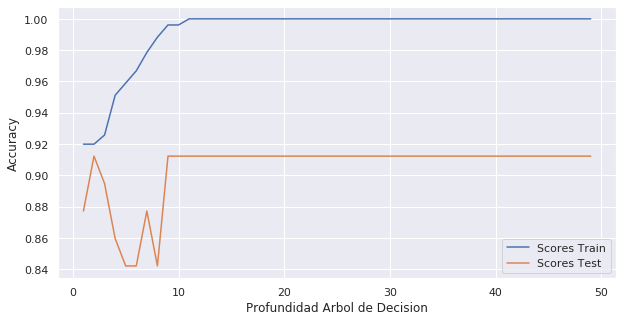

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(profundidades,scores_train, label = 'Scores Train')
plt.plot(profundidades,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¡Pero lo ideal sería graficar la curva de validación aplicando validación cruzada!

In [ ]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

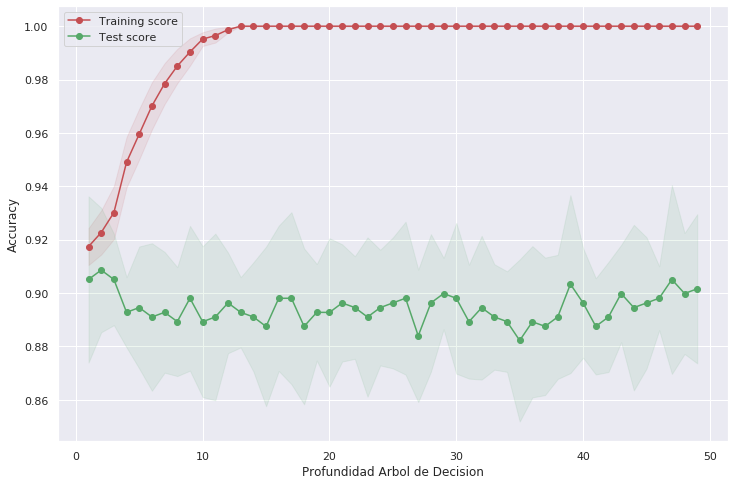

In [ ]:
plt.figure(figsize=(12,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

**Ejercicio:** Hacer una curva de validación para un modelo de KNN en función de la cantidad de vecinos, usando además validación cruzada.

## 3. Curva de ROC en Scikit-Learn

En primer lugar, dejamos el link a la Documentación de [Curvas de ROC en Scikit-Learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importamos las librerías necesarias para graficar las curva de ROC y calcular el AUC.

In [ ]:
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Binarizamos `y_test`

In [ ]:
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
print(y_test[:5])

[[0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


In [ ]:
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)
print(y_score[:5])

[[0.2  0.41 0.39]
 [0.4  0.41 0.19]
 [0.2  0.41 0.39]
 [0.2  0.41 0.39]
 [0.2  0.41 0.39]]


Para tener en cuenta:

* `.predict()` dará como salida un 0 o un 1.
* `.predict_proba()` dará como salida una estimación de la probabilidad.

In [ ]:
# Computamos los valores de FPR y TPR, para poder luego realizar el gráfico de la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

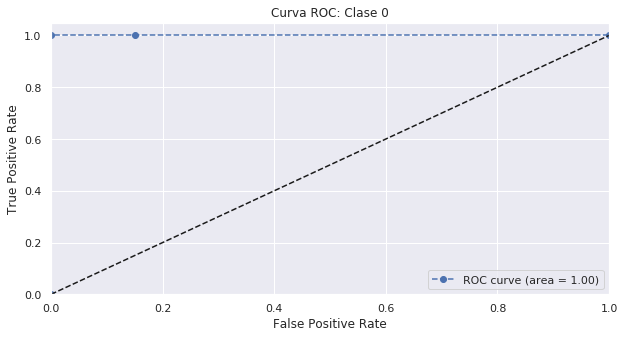

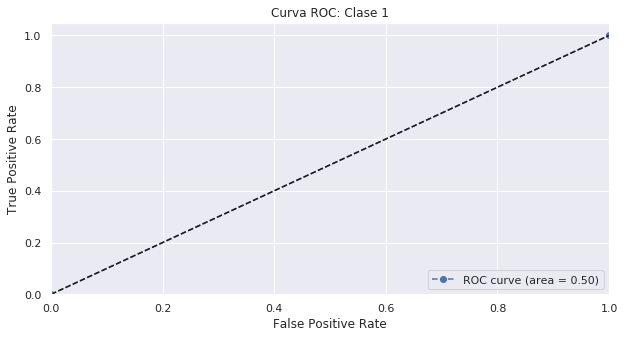

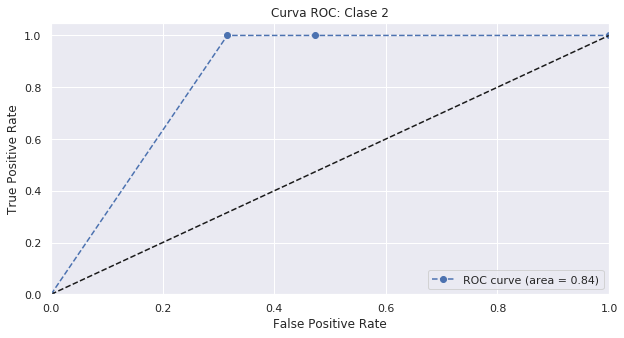

In [ ]:
for i in range(n_classes):
    plt.figure(figsize=(10,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.show()

**Ejercicio:** Buscá algún dataset de clasificación binario (por ejemplo: como el de la primera parte de este notebook), entrena un modelo a tu elección y grafica sus curvas de ROC.